Dataset sources

https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/data

News articles of class "world" (1), "sports" (2), "business" (3), and "Science" (4)

The dataset only take 3000 sample, with four class

Features used in this submission :

1. Tokenizer Keras
2. Stopword removal from nltk
3. Embedding layer

dataset_url = "https://github.com/priaJuli/Project-ML-Dicoding/blob/master/AG-News-dataset.zip"

The seed number used in this submission = 42,

The number 42 is a magic number that is often used by programmers.

In [1]:
import zipfile,os

datasetpath = '/content/AG-News-dataset.zip'

if not os.path.isfile(datasetpath):
    !wget "https://raw.githubusercontent.com/priaJuli/Project-ML-Dicoding/master/AG-News-dataset.zip"
    zip_ref = zipfile.ZipFile(datasetpath, 'r')
    zip_ref.extractall('/content/tmp/')
    zip_ref.close()

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder


path_train = "/content/tmp/train.csv"
path_test = "/content/tmp/test.csv"

## Loading data
df = pd.read_csv(path_train, sep=',')
df = df.sample(n=3000, random_state=1)

## Reshape data for onehotencoder
label = df['Class Index'].values.reshape(-1, 1)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(label)

## Transform label to categorical label
y = enc.transform(label).toarray()

## Combine column title and description for feature used in this submission
df['text'] = df['Title'] + ' ' + df['Description']



In [3]:
df.head()

,Class Index,Title,Description,text
76467,4,BEA buzzing about Beehive,"BURLINGAME, CALIF.-- BEA Systems is expanding ...","BEA buzzing about Beehive BURLINGAME, CALIF.--..."
27991,3,Saudi Violence Pushes Oil Prices Higher,Oil prices were forced higher today by an outb...,Saudi Violence Pushes Oil Prices Higher Oil pr...
62646,1,Storm shows Haiti #39;s straits,Muddy waters still occupied the heart of Gonai...,Storm shows Haiti #39;s straits Muddy waters s...
28374,4,Crews Fail to Find Tree-Killing Beetle (AP),AP - Survey crews searching through woods and ...,Crews Fail to Find Tree-Killing Beetle (AP) AP...
98305,2,Justice Is Too Light,It's too bad Stern stopped at 30 games for Ron...,Justice Is Too Light It's too bad Stern stoppe...


In [4]:
df.count()

Class Index    3000
Title          3000
Description    3000
text           3000
dtype: int64

In [5]:
np.unique(df['Class Index'], return_counts=True)

(array([1, 2, 3, 4]), array([757, 776, 748, 719]))


Clean string

In [6]:
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')

def clean(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]',' ',text)
    text = text.split()
    text = [ i for i in text if i not in stopwords.words('english')]
    return ' '.join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df['text'] = df['text'].apply(clean)

In [8]:
df.head(3)

,Class Index,Title,Description,text
76467,4,BEA buzzing about Beehive,"BURLINGAME, CALIF.-- BEA Systems is expanding ...",bea buzzing beehive burlingame calif bea syste...
27991,3,Saudi Violence Pushes Oil Prices Higher,Oil prices were forced higher today by an outb...,saudi violence pushes oil prices higher oil pr...
62646,1,Storm shows Haiti #39;s straits,Muddy waters still occupied the heart of Gonai...,storm shows haiti 39 straits muddy waters stil...


In [9]:
from sklearn.model_selection import train_test_split

kalimat = df['text'].values

## Split dataset
kalimat_latih, kalimat_test, y_latih, y_test = train_test_split(kalimat, y, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=14000, oov_token='x')
tokenizer.fit_on_texts(kalimat_latih)
tokenizer.fit_on_texts(kalimat_test)

sekuens_latih = tokenizer.texts_to_sequences(kalimat_latih)
sekuens_test = tokenizer.texts_to_sequences(kalimat_test)

padded_latih = pad_sequences(sekuens_latih, maxlen=120)
padded_test = pad_sequences(sekuens_test, maxlen=120)


In [11]:
print(len(sekuens_latih[0]))

32


In [12]:
padded_test.shape

(600, 120)

In [13]:
padded_latih.shape

(2400, 120)

In [14]:
print(np.amax(padded_latih))
print(np.amax(padded_test))

12741
13999


In [15]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(14000, 128, input_length=120),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=42),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

## Create custom adam optimizers
adamoptz = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',optimizer=adamoptz,metrics=['accuracy'])

From my perspective,

if the accuracy of neural network training reaches the maximum value,

it can be concluded that the model is overfit

In [16]:
## Create custom callbacks for stopping criteria
class ValidationMax(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ValidationMax, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True
            print("Epoch {}: Stop training because validation accuracy reach more than {}%, validation accuracy = {:7.2f}".format(epoch+1, (self.threshold * 100), val_acc))
        elif logs["accuracy"] >= 1.0:
            self.model.stop_training = True
            print("Epoch {}: Stop training because training accuracy reach max, validation accuracy = {:7.2f}".format(epoch+1, val_acc))

In [17]:
# Custom learning rate
def lr_scheduler(epoch):
  return 0.001 * (0.1 ** (epoch // 5))

# Define the callback for LR Scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [18]:
num_epochs = 50

stopmax = ValidationMax(threshold=0.85)

history = model.fit(padded_latih, y_latih, batch_size=32, epochs=num_epochs,
                    validation_data=(padded_test, y_test), steps_per_epoch=24, verbose=2, callbacks=[stopmax])

Epoch 1/50
24/24 - 8s - loss: 1.3885 - accuracy: 0.2474 - val_loss: 1.3837 - val_accuracy: 0.2333 - 8s/epoch - 343ms/step
Epoch 2/50
24/24 - 4s - loss: 1.3303 - accuracy: 0.4141 - val_loss: 1.0782 - val_accuracy: 0.6333 - 4s/epoch - 158ms/step
Epoch 3/50
24/24 - 4s - loss: 0.9347 - accuracy: 0.6432 - val_loss: 0.7009 - val_accuracy: 0.7150 - 4s/epoch - 167ms/step
Epoch 4/50
24/24 - 4s - loss: 0.5035 - accuracy: 0.8086 - val_loss: 0.6848 - val_accuracy: 0.7617 - 4s/epoch - 158ms/step
Epoch 5/50
24/24 - 4s - loss: 0.4484 - accuracy: 0.8451 - val_loss: 0.5942 - val_accuracy: 0.7800 - 4s/epoch - 158ms/step
Epoch 6/50
24/24 - 4s - loss: 0.3628 - accuracy: 0.8698 - val_loss: 0.6632 - val_accuracy: 0.7683 - 4s/epoch - 167ms/step
Epoch 7/50
24/24 - 4s - loss: 0.2651 - accuracy: 0.9167 - val_loss: 0.7220 - val_accuracy: 0.7467 - 4s/epoch - 166ms/step
Epoch 8/50
24/24 - 4s - loss: 0.1515 - accuracy: 0.9505 - val_loss: 0.8106 - val_accuracy: 0.7667 - 4s/epoch - 168ms/step
Epoch 9/50
24/24 - 4s - 

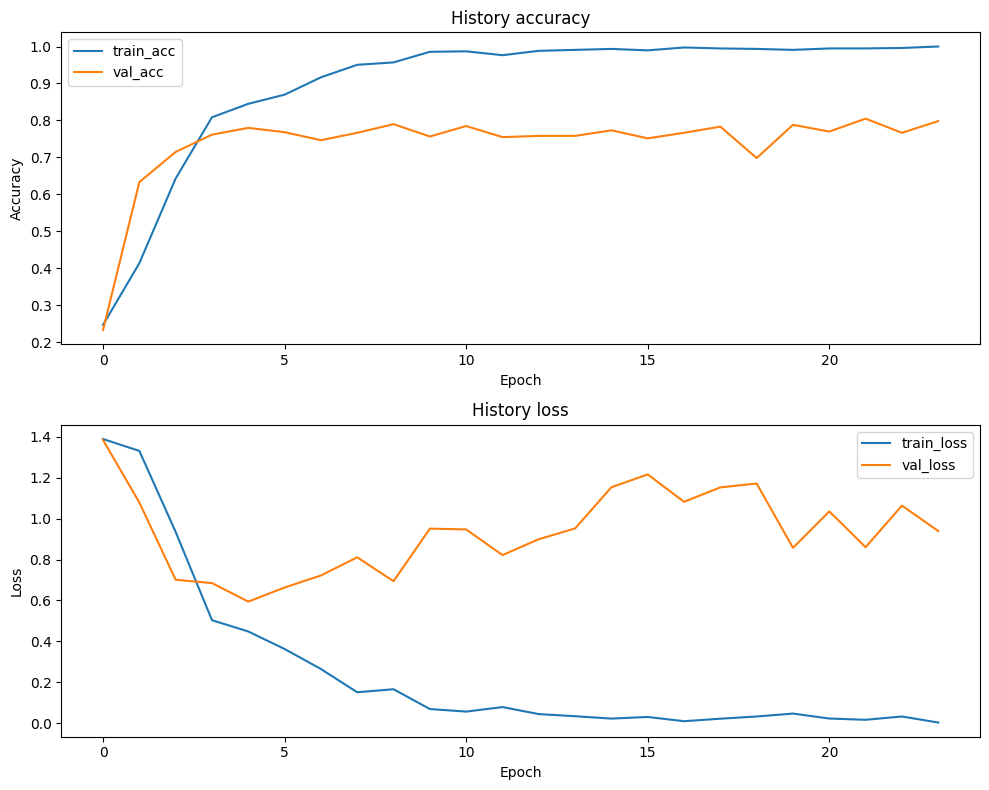

In [19]:
import matplotlib.pyplot as plt

# Create a subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the training and validation accuracy on the first subplot
ax1.set_title("History accuracy")
ax1.plot(history.history['accuracy'], label='train_acc')
ax1.plot(history.history['val_accuracy'], label='val_acc')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

# Plot the training and validation loss on the second subplot
ax2.set_title("History loss")
ax2.plot(history.history['loss'], label='train_loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

# Show the plot
plt.tight_layout()
plt.show()